In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,10)
from datetime import timedelta
from keras.models import *
from keras.layers import *
import seaborn as sns

In [2]:
dataframe = pd.read_csv("QBElec.csv")
HUElec = pd.melt(dataframe, id_vars=["Date"], var_name='time')
HUElec['time'] = pd.to_timedelta(HUElec['time'].apply(lambda t: f"{t[:5]}:00")) - timedelta(minutes=30)
HUElec['Date'] = pd.to_datetime(HUElec['Date'], format="%m/%d/%Y")
HUElec['Datetime'] = HUElec['Date'] + HUElec['time']
HUElec = HUElec.set_index('Datetime')
HUElec = HUElec.drop(['Date', 'time'], axis=1).sort_index()

# View formatted data
HUElec.head(100)

,value
Datetime,
2008-03-03 00:00:00,0.000
2008-03-03 00:30:00,0.000
2008-03-03 01:00:00,0.000
2008-03-03 01:30:00,0.000
2008-03-03 02:00:00,0.000
...,...
2008-03-04 23:30:00,54.582
2008-03-05 00:00:00,55.865
2008-03-05 00:30:00,56.000


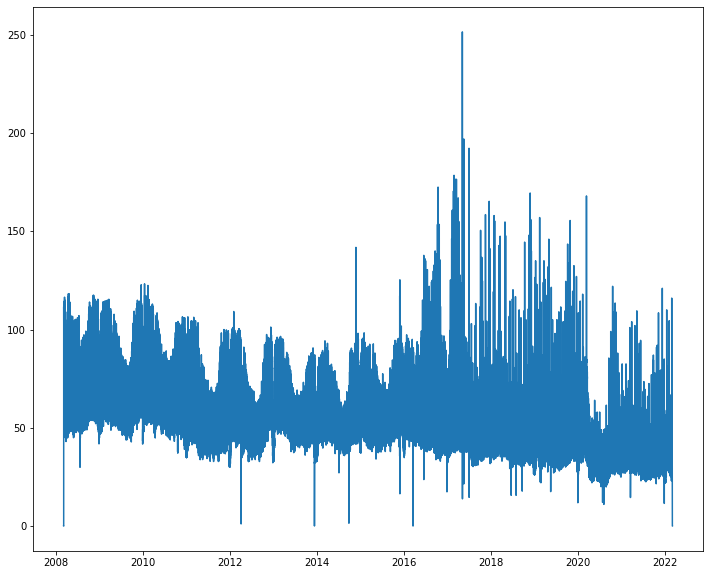

In [3]:
plt.plot(HUElec)

In [9]:
df = HUElec.resample(rule='D').mean()
df.head()

,value
Datetime,
2008-03-03,50.036833
2008-03-04,79.146396
2008-03-05,80.725021
2008-03-06,79.155750
2008-03-07,77.895188


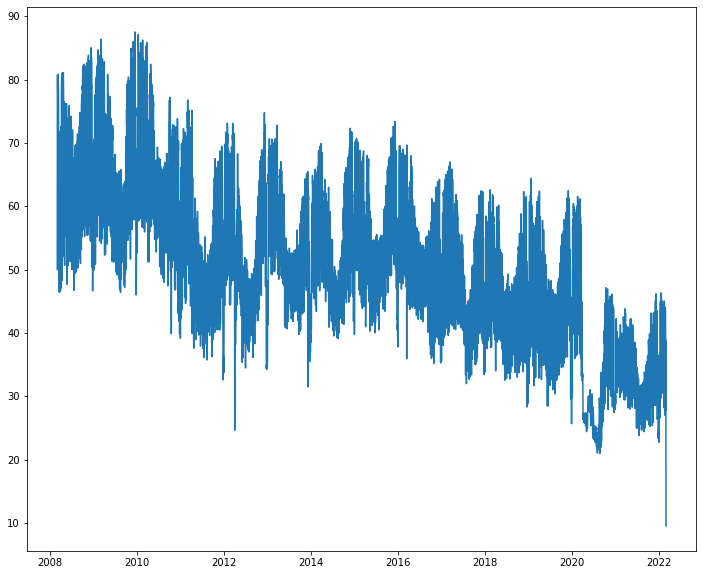

In [10]:
plt.plot(df)

In [11]:
len(df)

5112

In [12]:
df = df.reset_index()

df.describe(include='all')

<ipython-input-12-3c942f044bca>:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')


,Datetime,value
count,5112,5112.000000
unique,5112,NaN
top,2020-08-26 00:00:00,NaN
freq,1,NaN
first,2008-03-03 00:00:00,NaN
last,2022-03-01 00:00:00,NaN
mean,NaN,52.847789
std,NaN,13.789697
min,NaN,9.531250
25%,NaN,43.008630


In [13]:
df.head()

,Datetime,value
0,2008-03-03,50.036833
1,2008-03-04,79.146396
2,2008-03-05,80.725021
3,2008-03-06,79.155750
4,2008-03-07,77.895188


<AxesSubplot:xlabel='Datetime', ylabel='value'>

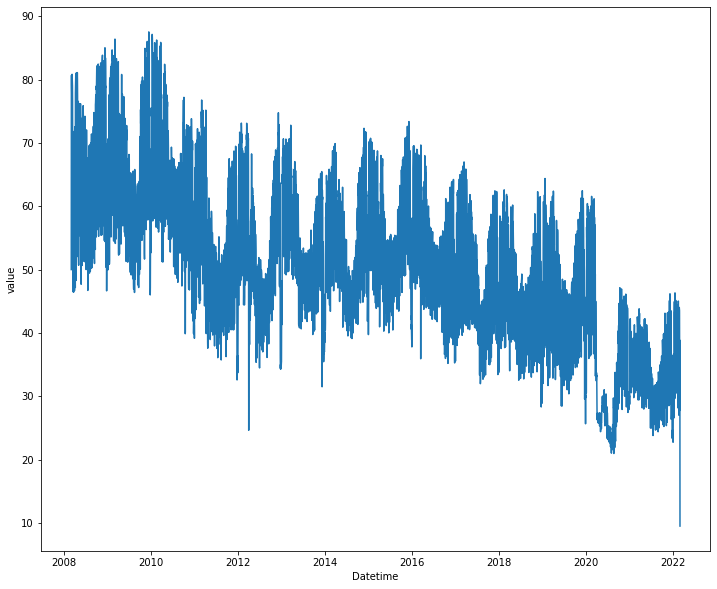

In [14]:
sns.lineplot(x=df['Datetime'], y=df['value'])

In [15]:
print('Start date: ', df['Datetime'].min())
print('End date: ', df['Datetime'].max())

Start date:  2008-03-03 00:00:00
End date:  2022-03-01 00:00:00


In [16]:
train, test = df.loc[df['Datetime'] <= '2019-12-31'], df.loc[df['Datetime'] > '2019-12-31']

In [17]:
train.head(), test.head()

(    Datetime      value
 0 2008-03-03  50.036833
 1 2008-03-04  79.146396
 2 2008-03-05  80.725021
 3 2008-03-06  79.155750
 4 2008-03-07  77.895188,
        Datetime      value
 4321 2020-01-01  32.864583
 4322 2020-01-02  43.052083
 4323 2020-01-03  45.677083
 4324 2020-01-04  30.489583
 4325 2020-01-05  30.614583)

In [18]:
from sklearn.preprocessing import *

scaler = StandardScaler()
scaler = scaler.fit(train[['value']])

In [19]:
train['value'] = scaler.transform(train[['value']])
test['value'] = scaler.transform(test[['value']])

<ipython-input-19-0d4a6bf2fb1b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['value'] = scaler.transform(train[['value']])
<ipython-input-19-0d4a6bf2fb1b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['value'] = scaler.transform(test[['value']])


In [20]:
train[:5]

,Datetime,value
0,2008-03-03,-0.501653
1,2008-03-04,1.926245
2,2008-03-05,2.057911
3,2008-03-06,1.927026
4,2008-03-07,1.821888


In [21]:
seq_size = 30

In [22]:
def to_sequence(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x) - seq_size):
        x_values.append(x.iloc[i: (i + seq_size)].values)
        y_values.append(y.iloc[i + seq_size])

    return np.array(x_values), np.array(y_values)

In [23]:
trainX, trainY = to_sequence(train[['value']], train[['value']], seq_size)
testX, testY = to_sequence(test[['value']], test[['value']], seq_size)

In [24]:
trainX.shape

(4291, 30, 1)

In [25]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(rate=0.2))

model.add(RepeatVector(trainX.shape[1]))

model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

In [26]:
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/10
121/121 [==============================] - 72s 89ms/step - loss: 0.6240 - val_loss: 0.5387
Epoch 2/10
121/121 [==============================] - 6s 50ms/step - loss: 0.5110 - val_loss: 0.4892
Epoch 3/10
121/121 [==============================] - 6s 51ms/step - loss: 0.4634 - val_loss: 0.4507
Epoch 4/10
121/121 [==============================] - 6s 49ms/step - loss: 0.3770 - val_loss: 0.2801
Epoch 5/10
121/121 [==============================] - 6s 49ms/step - loss: 0.2710 - val_loss: 0.3001
Epoch 6/10
121/121 [==============================] - 8s 66ms/step - loss: 0.2490 - val_loss: 0.2476
Epoch 7/10
121/121 [==============================] - 6s 50ms/step - loss: 0.2258 - val_loss: 0.2161
Epoch 8/10
121/121 [==============================] - 6s 48ms/step - loss: 0.2214 - val_loss: 0.1969
Epoch 9/10
121/121 [==============================] - 5s 42ms/step - loss: 0.2134 - val_loss: 0.2616
Epoch 10/10
121/121 [==============================] - 5s 41ms/step - loss: 0.2106 - val_l

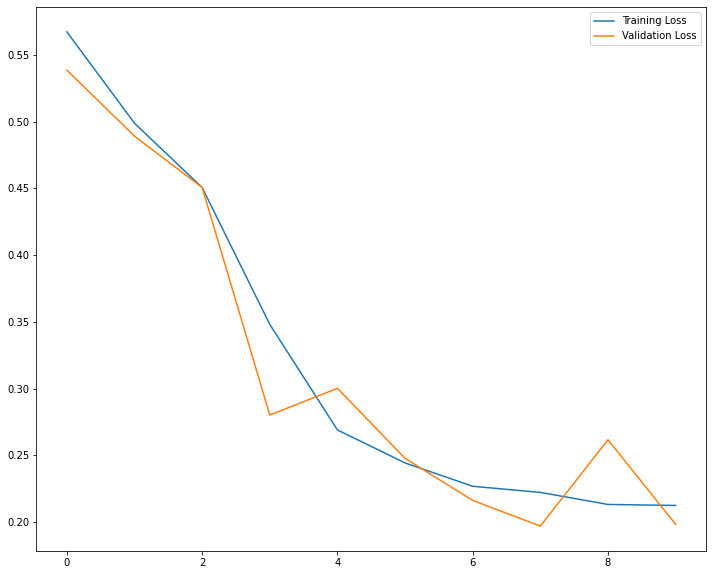

In [27]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

(array([135., 243., 313., 370., 508., 520., 423., 291., 228., 196., 172.,
        188., 148., 121., 110.,  91.,  61.,  64.,  36.,  32.,  10.,   9.,
          7.,   4.,   4.,   2.,   2.,   1.,   1.,   1.]),
 array([0.20403804, 0.27774058, 0.35144311, 0.42514564, 0.49884818,
        0.57255071, 0.64625324, 0.71995578, 0.79365831, 0.86736084,
        0.94106338, 1.01476591, 1.08846845, 1.16217098, 1.23587351,
        1.30957605, 1.38327858, 1.45698111, 1.53068365, 1.60438618,
        1.67808871, 1.75179125, 1.82549378, 1.89919631, 1.97289885,
        2.04660138, 2.12030391, 2.19400645, 2.26770898, 2.34141151,
        2.41511405]),
 <BarContainer object of 30 artists>)

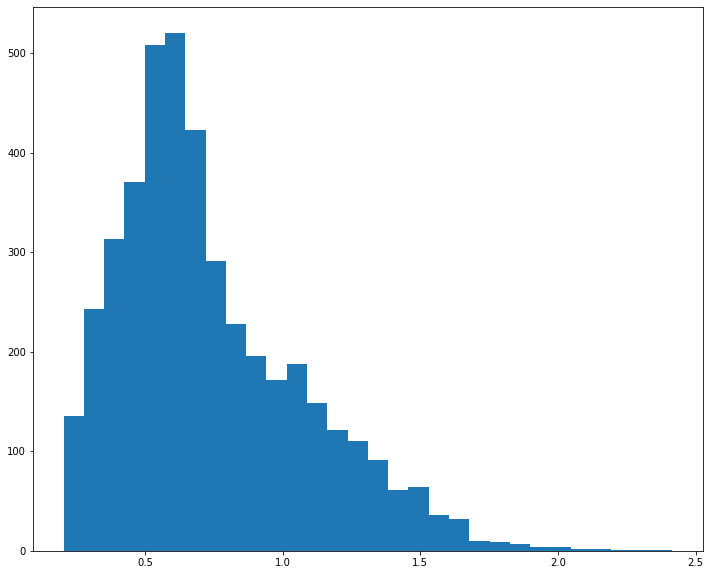

In [28]:
trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
plt.hist(trainMAE, bins=30)

In [39]:
max_trainMAE = 1.2

In [30]:
testPredict = model.predict(testX)

(array([ 10.,  11.,  45.,  63., 126.,  88.,  87.,  71.,  60.,  41.,  49.,
         31.,  17.,  12.,  11.,   4.,   2.,   6.,   5.,   6.,   7.,   3.,
          2.,   2.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([0.1593829 , 0.20582779, 0.25227268, 0.29871757, 0.34516246,
        0.39160735, 0.43805225, 0.48449714, 0.53094203, 0.57738692,
        0.62383181, 0.6702767 , 0.7167216 , 0.76316649, 0.80961138,
        0.85605627, 0.90250116, 0.94894605, 0.99539095, 1.04183584,
        1.08828073, 1.13472562, 1.18117051, 1.22761541, 1.2740603 ,
        1.32050519, 1.36695008, 1.41339497, 1.45983986, 1.50628476,
        1.55272965]),
 <BarContainer object of 30 artists>)

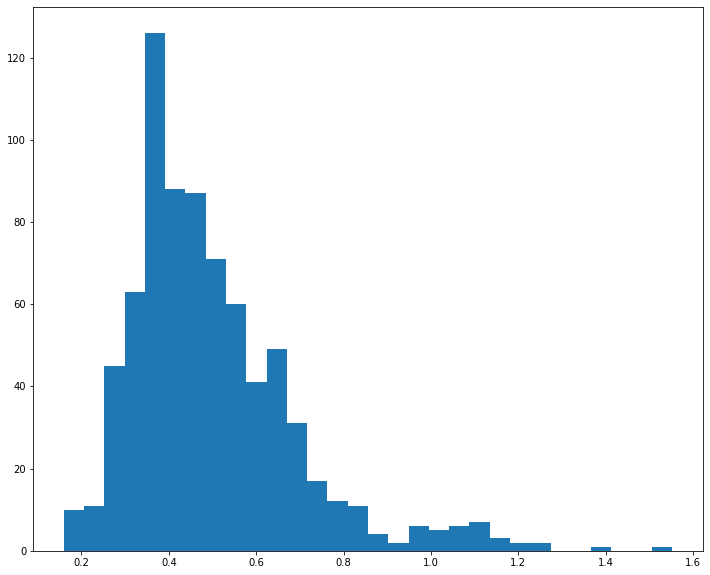

In [31]:
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=30)

In [40]:
# Capture all details in a Dataframe for easy plotting
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['Test MAE'] = testMAE
anomaly_df['Max Train MAE'] = max_trainMAE
anomaly_df['Anomaly'] = anomaly_df['Test MAE'] > anomaly_df['Max Train MAE']
anomaly_df['value'] = test[seq_size:]['value']

<AxesSubplot:xlabel='Datetime', ylabel='Test MAE'>

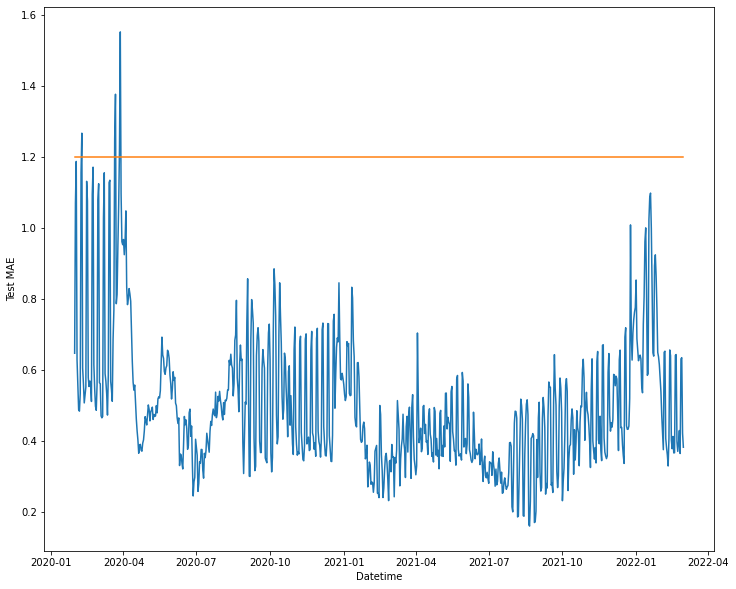

In [41]:
# plot testMAE vs max_trainMAE
sns.lineplot(x=anomaly_df['Datetime'], y=anomaly_df['Test MAE'])
sns.lineplot(x=anomaly_df['Datetime'], y=anomaly_df['Max Train MAE'])

In [42]:
anomaly_df

,Datetime,value,Test MAE,Max Train MAE,Anomaly
4351,2020-01-31,0.093883,0.646724,1.2,False
4352,2020-02-01,-1.483003,1.069417,1.2,False
4353,2020-02-02,-1.588997,1.187528,1.2,False
4354,2020-02-03,0.169469,0.628119,1.2,False
4355,2020-02-04,0.219860,0.562270,1.2,False
...,...,...,...,...,...
5107,2022-02-25,-1.043386,0.364002,1.2,False
5108,2022-02-26,-2.130699,0.630927,1.2,False
5109,2022-02-27,-2.357023,0.634220,1.2,False
5110,2022-02-28,-1.432177,0.421468,1.2,False


In [43]:
anomalies = anomaly_df.loc[anomaly_df['Anomaly'] == True]

In [44]:
anomalies

,Datetime,value,Test MAE,Max Train MAE,Anomaly
4360,2020-02-09,-1.621723,1.267201,1.2,True
4401,2020-03-21,-1.904374,1.252063,1.2,True
4402,2020-03-22,-1.843992,1.376961,1.2,True
4407,2020-03-27,-1.913062,1.223435,1.2,True
4408,2020-03-28,-1.966928,1.552730,1.2,True


<AxesSubplot:xlabel='Datetime'>

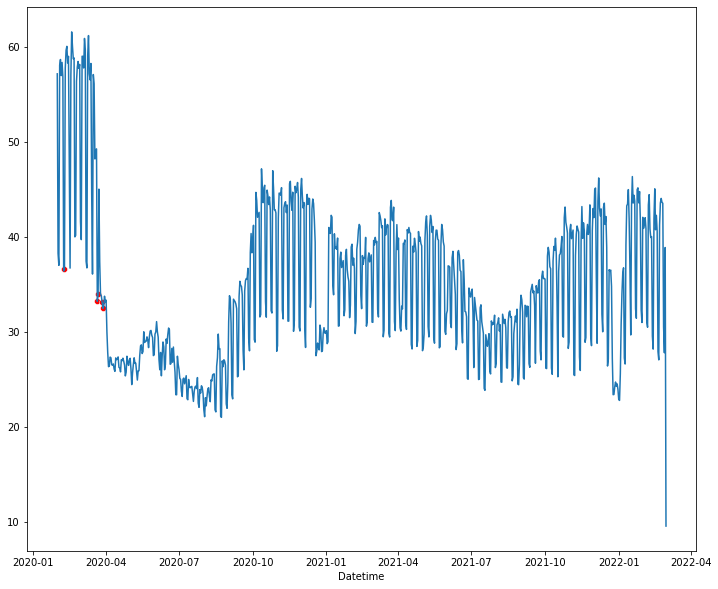

In [45]:
# Plot anomalies
sns.lineplot(x=anomaly_df['Datetime'], y=scaler.inverse_transform(anomaly_df['value']))
sns.scatterplot(x=anomalies['Datetime'], y=scaler.inverse_transform(anomalies['value']), color='r')

# Predict 90 days (3-months ahead)